In [21]:
!pip install xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('NYC_Crash_Model_Final.csv')

# Filtreleme
hedef_sutunlar = ['LATITUDE', 'LONGITUDE', 'HOUR', 'IS_MULTI_VEHICLE']
extra_cols = [col for col in df.columns if 'VEHICLE_' in col or 'FACTOR_' in col]
hedef_sutunlar.extend(extra_cols)
if 'SEVERITY' in df.columns and 'SEVERITY' not in hedef_sutunlar:
    hedef_sutunlar.append('SEVERITY')

df_filtered = df[hedef_sutunlar].copy()

# Temizlik
if 'SEVERITY' in df_filtered.columns:
    df_filtered['SEVERITY'] = df_filtered['SEVERITY'].replace(2, 1)

y = df_filtered['SEVERITY']
X = df_filtered.drop(columns=['SEVERITY']).astype('float32')

# Bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Veri Hazır! {X_train.shape[0]} eğitim örneği var.")

Veri Hazır! 1528858 eğitim örneği var.


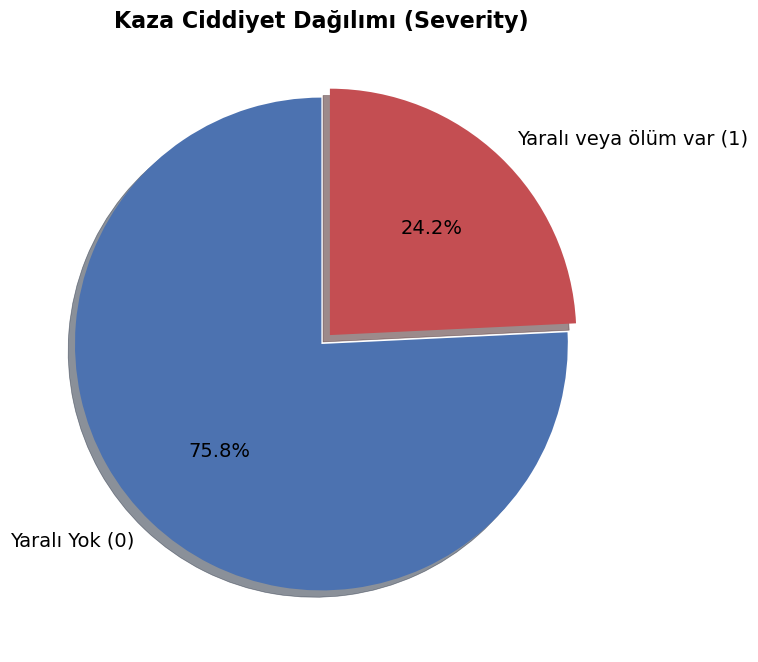

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stil ayarları
plt.style.use('ggplot')
colors = ['#4c72b0', '#c44e52'] # Mavi ve Kırmızı tonları

# Veriyi hazırla
severity_counts = df_filtered['SEVERITY'].value_counts()
labels = ['Yaralı Yok (0)', 'Yaralı veya ölüm var (1)']

# Grafiği çiz
plt.figure(figsize=(8, 8))
plt.pie(severity_counts, labels=labels, autopct='%1.1f%%', startangle=90, 
        colors=colors, explode=(0, 0.05), shadow=True, textprops={'fontsize': 14})
plt.title('Kaza Ciddiyet Dağılımı (Severity)', fontsize=16, fontweight='bold')
plt.show()

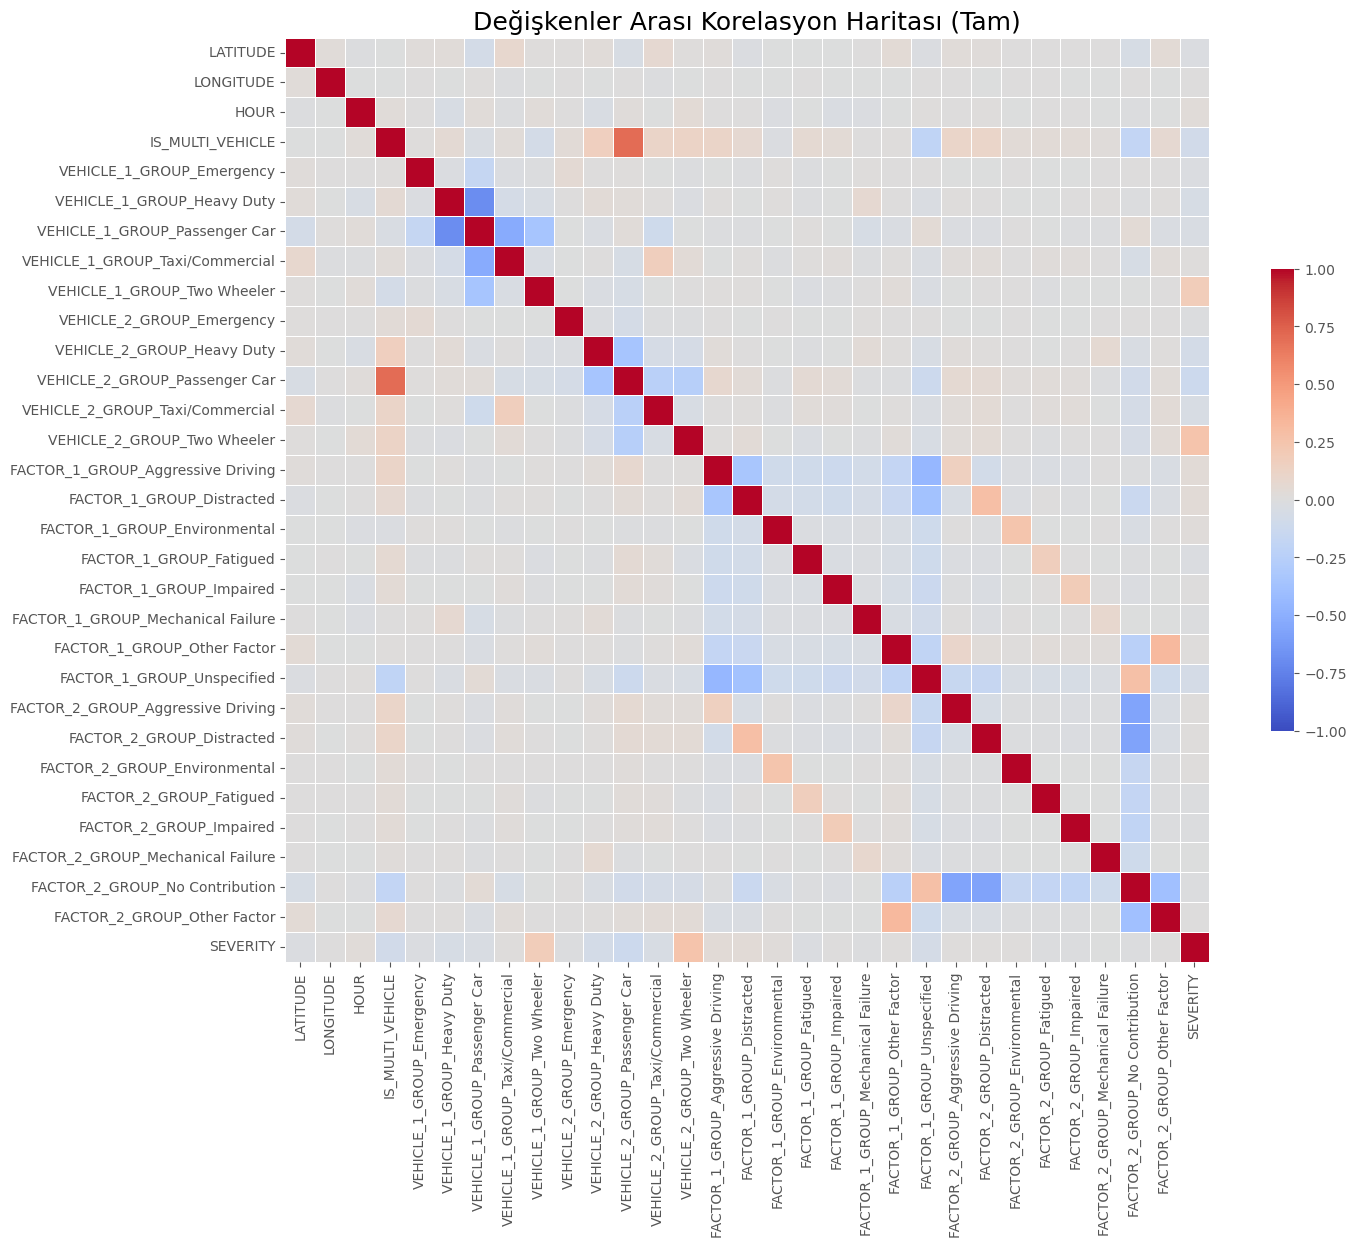

In [9]:
plt.figure(figsize=(16, 12))

# Sadece sayısal sütunları alalım
corr_matrix = df_filtered.corr()

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Değişkenler Arası Korelasyon Haritası (Tam)', fontsize=18)
plt.show()

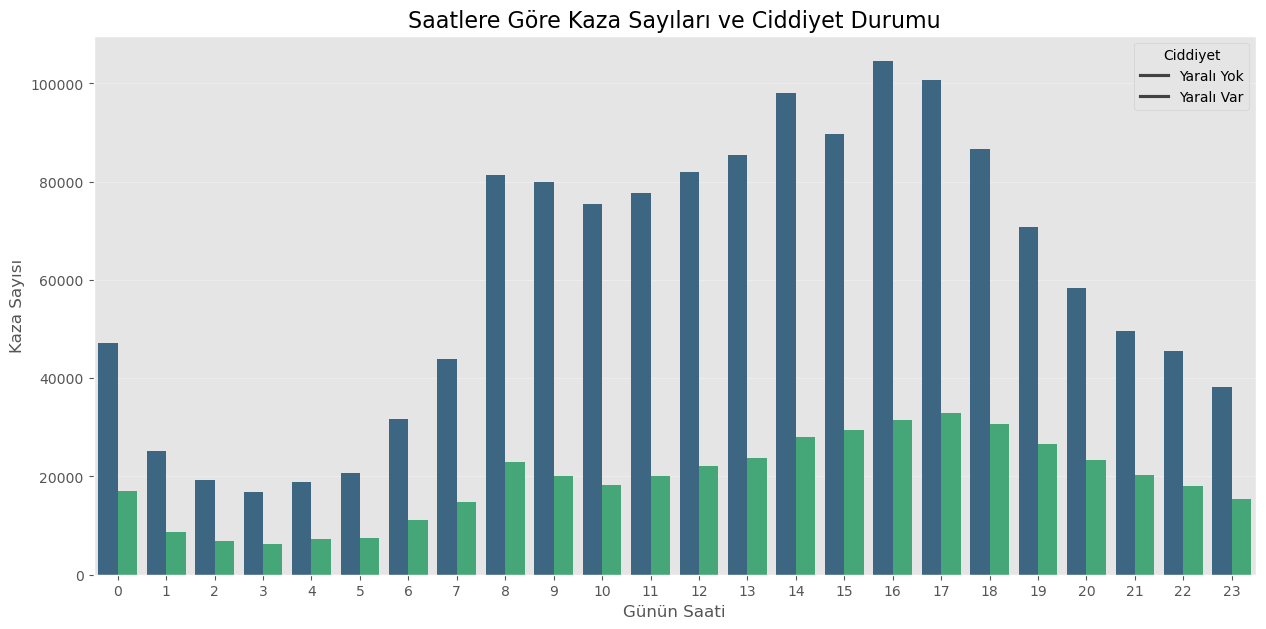

In [6]:
plt.figure(figsize=(15, 7))

# Veriyi saat bazında grupla
hourly_data = df_filtered.groupby(['HOUR', 'SEVERITY']).size().reset_index(name='Counts')

sns.barplot(x='HOUR', y='Counts', hue='SEVERITY', data=hourly_data, palette='viridis')

plt.title('Saatlere Göre Kaza Sayıları ve Ciddiyet Durumu', fontsize=16)
plt.xlabel('Günün Saati', fontsize=12)
plt.ylabel('Kaza Sayısı', fontsize=12)
plt.legend(title='Ciddiyet', loc='upper right', labels=['Yaralı Yok', 'Yaralı Var'])
plt.grid(axis='y', alpha=0.3)
plt.show()

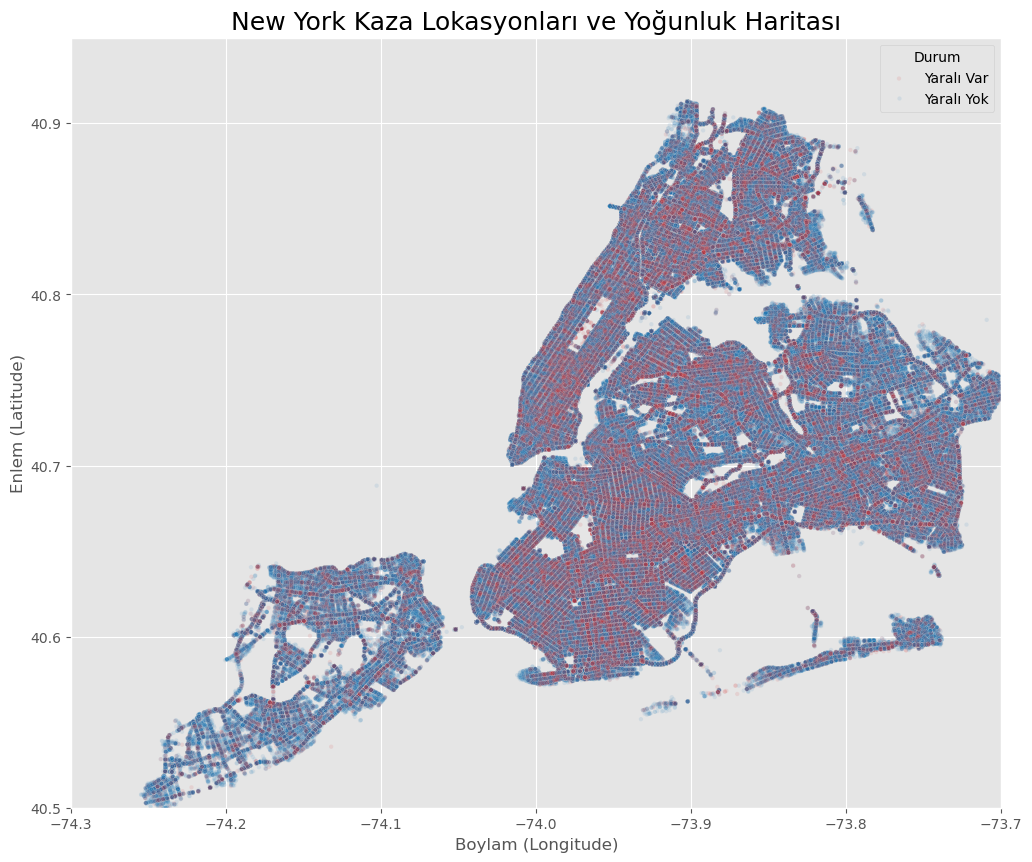

In [7]:
plt.figure(figsize=(12, 10))

# Yaralı olanları Kırmızı, olmayanları Mavi ile gösterelim
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='SEVERITY', data=df_filtered, 
                palette={0: '#1f77b4', 1: '#d62728'}, alpha=0.1, s=10, legend='full')

plt.title('New York Kaza Lokasyonları ve Yoğunluk Haritası', fontsize=18)
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.xlim(-74.3, -73.7) 
plt.ylim(40.5, 40.95)
plt.legend(title='Durum', labels=['Yaralı Var', 'Yaralı Yok']) 
plt.show()

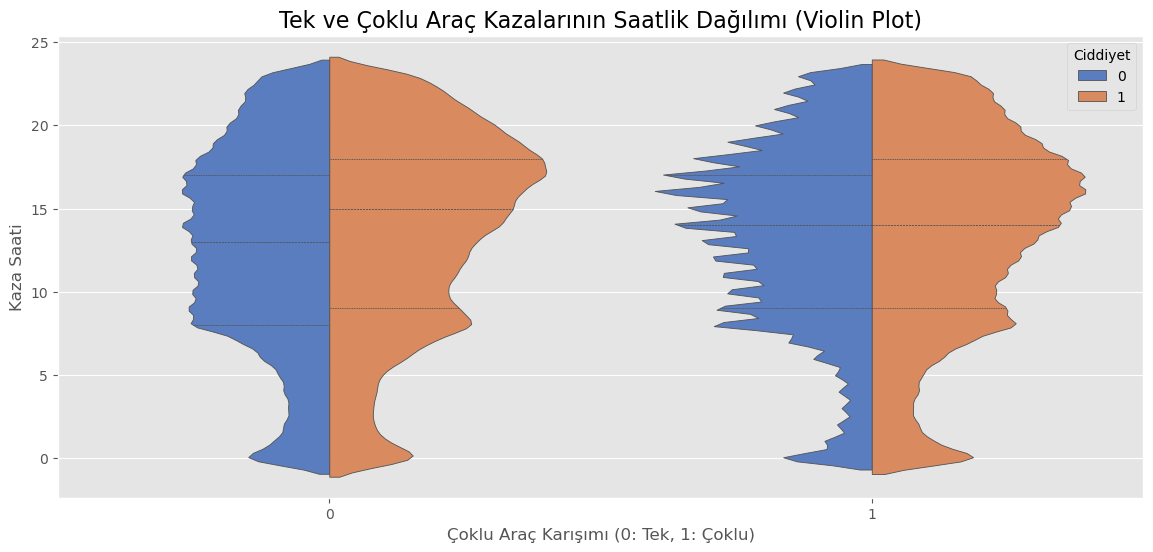

In [8]:
# HÜCRE EKLE: Tek/Çoklu Araç Karışımının Saatlik Dağılımı
plt.figure(figsize=(14, 6))

sns.violinplot(x='IS_MULTI_VEHICLE', y='HOUR', hue='SEVERITY', data=df_filtered, 
               split=True, palette='muted', inner='quartile')

plt.title('Tek ve Çoklu Araç Kazalarının Saatlik Dağılımı (Violin Plot)', fontsize=16)
plt.xlabel('Çoklu Araç Karışımı (0: Tek, 1: Çoklu)', fontsize=12)
plt.ylabel('Kaza Saati', fontsize=12)
plt.legend(title='Ciddiyet', loc='upper right')
plt.show()

In [23]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from time import time
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier


# XGBoost icin scale_pos_weight hesabi
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
spw_value = neg_count / pos_count

model_results = []

def train_and_evaluate(model, name):
    print(f"{name} modeli eğitiliyor...")
    start = time()
    model.fit(X_train, y_train)
    duration = time() - start
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"Eğitim tamamlandı. Süre: {duration:.2f}sn")
    print(f"AUC: {auc:.4f} | F1 Skoru: {f1:.4f} | Doğruluk: {acc:.4f}")
    print("-" * 50)
    
    model_results.append({
        'Model': name,
        'AUC': auc,
        'F1 Score': f1,
        'Accuracy': acc,
        'Duration': duration
    })

# 1. Bagging Classifier
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    n_estimators=50, 
    random_state=42
)
train_and_evaluate(bagging, "Bagging Classifier")

# 2. Random Forest
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    class_weight='balanced', 
    random_state=42
)
train_and_evaluate(rf, "Random Forest")

# 3. AdaBoost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
train_and_evaluate(ada, "AdaBoost")

# 4. Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42
)
train_and_evaluate(gb, "Gradient Boosting")

# 5. XGBoost
xgb = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    scale_pos_weight=spw_value,
    eval_metric='logloss',
    random_state=42
)
train_and_evaluate(xgb, "XGBoost")

Bagging Classifier modeli eğitiliyor...
Eğitim tamamlandı. Süre: 444.89sn
AUC: 0.6760 | F1 Skoru: 0.7348 | Doğruluk: 0.7537
--------------------------------------------------
Random Forest modeli eğitiliyor...
Eğitim tamamlandı. Süre: 128.44sn
AUC: 0.7100 | F1 Skoru: 0.7281 | Doğruluk: 0.7221
--------------------------------------------------
AdaBoost modeli eğitiliyor...
Eğitim tamamlandı. Süre: 1.86sn
AUC: 0.5590 | F1 Skoru: 0.7144 | Doğruluk: 0.7791
--------------------------------------------------
Gradient Boosting modeli eğitiliyor...
Eğitim tamamlandı. Süre: 298.73sn
AUC: 0.7084 | F1 Skoru: 0.7414 | Doğruluk: 0.7904
--------------------------------------------------
XGBoost modeli eğitiliyor...
Eğitim tamamlandı. Süre: 3.05sn
AUC: 0.7109 | F1 Skoru: 0.7160 | Doğruluk: 0.7043
--------------------------------------------------


MODEL KARŞILAŞTIRMA SONUÇLARI
                Model       AUC  F1 Score  Accuracy    Duration
0             XGBoost  0.710920  0.716016  0.704295    3.047688
1       Random Forest  0.709990  0.728147  0.722081  128.440349
2   Gradient Boosting  0.708394  0.741360  0.790409  298.727103
3  Bagging Classifier  0.675966  0.734833  0.753683  444.892891
4            AdaBoost  0.558960  0.714377  0.779116    1.862983


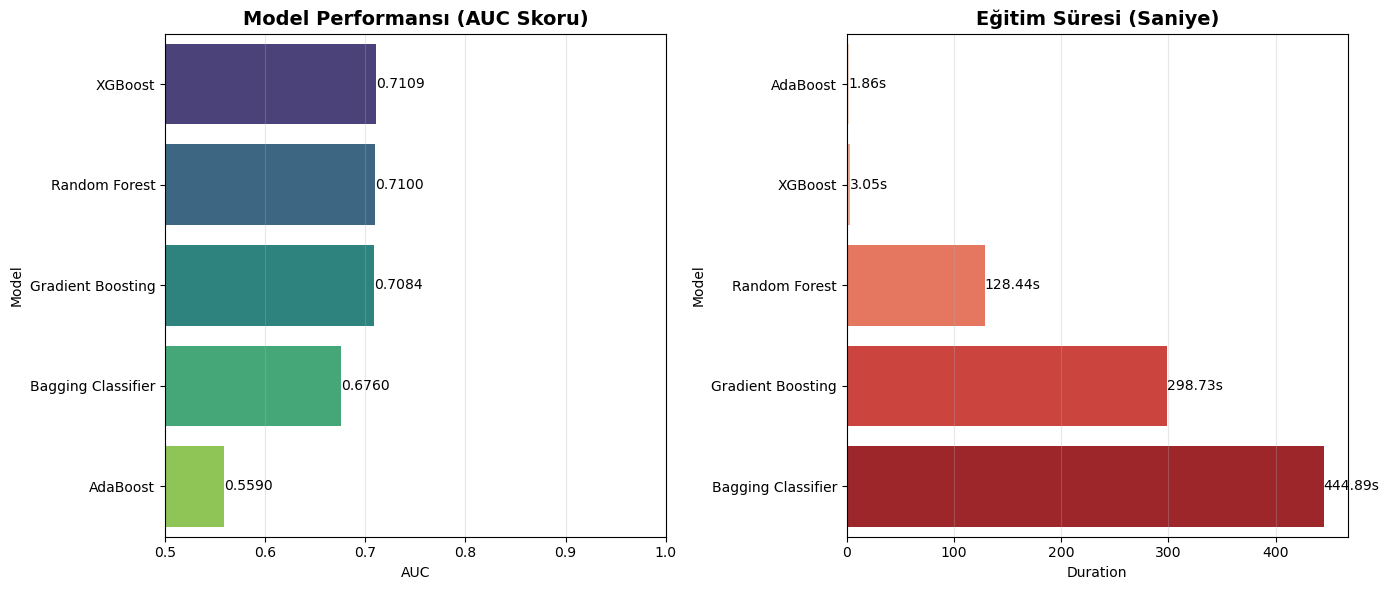


FİNAL SONUCU:
Test edilen modeller arasında en yüksek performansı XGBoost gösterdi.
En İyi AUC Skoru: 0.7109


In [24]:
results_df = pd.DataFrame(model_results).sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("MODEL KARŞILAŞTIRMA SONUÇLARI")
print(results_df.to_string())

plt.figure(figsize=(14, 6))

# 1. Grafik: AUC Skorları
plt.subplot(1, 2, 1)
sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
plt.title('Model Performansı (AUC Skoru)', fontsize=14, fontweight='bold')
plt.xlim(0.5, 1.0) 
plt.grid(axis='x', alpha=0.3)
for index, value in enumerate(results_df['AUC']):
    plt.text(value, index, f'{value:.4f}', va='center')

# 2. Grafik: Eğitim Süreleri
plt.subplot(1, 2, 2)
df_duration = results_df.sort_values(by='Duration')
sns.barplot(x='Duration', y='Model', data=df_duration, palette='Reds')
plt.title('Eğitim Süresi (Saniye)', fontsize=14, fontweight='bold') 
plt.grid(axis='x', alpha=0.3)
for index, value in enumerate(df_duration['Duration']):
    plt.text(value, index, f'{value:.2f}s', va='center')

plt.tight_layout()
plt.show()

best_model = results_df.iloc[0]
print(f"\nFİNAL SONUCU:") 
print(f"Test edilen modeller arasında en yüksek performansı {best_model['Model']} gösterdi.") 
print(f"En İyi AUC Skoru: {best_model['AUC']:.4f}")

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR...")

tuned_results = []

def tune_and_evaluate(model, params, name, n_iter=10):
    print(f"{name} için en iyi parametreler aranıyor")
    start = time()
    
    # Randomized Search Kurulumu
    # n_iter=10: Her model için rastgele 10 farklı kombinasyon dener
    # cv=3: 3 katmanlı çapraz doğrulama yapar
    random_search = RandomizedSearchCV(
        model, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='roc_auc', 
        cv=3, 
        verbose=1, 
        random_state=42, 
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    duration = time() - start
    
    # En İyi Model
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Tahminler
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"Optimizasyon Tamamlandı. Süre: {duration:.2f}sn")
    print(f"En İyi Parametreler: {best_params}")
    print(f"Optimize AUC: {auc:.4f} | F1 Skoru: {f1:.4f} | Doğruluk: {acc:.4f}")
    
    tuned_results.append({
        'Model': name + " (Tuned)",
        'AUC': auc,
        'F1 Score': f1,
        'Accuracy': acc,
        'Duration': duration,
        'Best Params': best_params
    })
    return best_model

rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_tuned = tune_and_evaluate(RandomForestClassifier(random_state=42), rf_params, "Random Forest", n_iter=10)

gb_params = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3)
}
gb_tuned = tune_and_evaluate(GradientBoostingClassifier(random_state=42), gb_params, "Gradient Boosting", n_iter=10)

# spw_value önceki hücreden geliyor
xgb_params = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [spw_value]
}
xgb_tuned = tune_and_evaluate(XGBClassifier(eval_metric='logloss', random_state=42), xgb_params, "XGBoost", n_iter=10)


HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR...
Random Forest için en iyi parametreler aranıyor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizasyon Tamamlandı. Süre: 2038.28sn
En İyi Parametreler: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 289}
Optimize AUC: 0.7134 | F1 Skoru: 0.7288 | Doğruluk: 0.7224
Gradient Boosting için en iyi parametreler aranıyor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizasyon Tamamlandı. Süre: 3003.38sn
En İyi Parametreler: {'learning_rate': np.float64(0.16703519227860275), 'max_depth': 5, 'n_estimators': 207, 'subsample': np.float64(0.8542703315240834)}
Optimize AUC: 0.7144 | F1 Skoru: 0.7431 | Doğruluk: 0.7908
XGBoost için en iyi parametreler aranıyor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizasyon Tamamlandı. Süre: 137.77sn
En İyi Parametreler: {'colsample_bytree': np.float64(0.8447411578889518), 'gamma': np.float64(0.069746930


OPTİMİZE EDİLMİŞ MODEL SONUÇLARI
                       Model       AUC  F1 Score  Accuracy     Duration                                                                                                                                                                                                                 Best Params
0            XGBoost (Tuned)  0.721491  0.715632  0.702306   137.770540  {'colsample_bytree': 0.8447411578889518, 'gamma': 0.06974693032602092, 'learning_rate': 0.06842892970704363, 'max_depth': 9, 'n_estimators': 289, 'scale_pos_weight': 3.1253811407508945, 'subsample': 0.6362425738131283}
1  Gradient Boosting (Tuned)  0.714445  0.743066  0.790770  3003.378783                                                                                                                {'learning_rate': 0.16703519227860275, 'max_depth': 5, 'n_estimators': 207, 'subsample': 0.8542703315240834}
2      Random Forest (Tuned)  0.713397  0.728832  0.722379  2038.278744                   

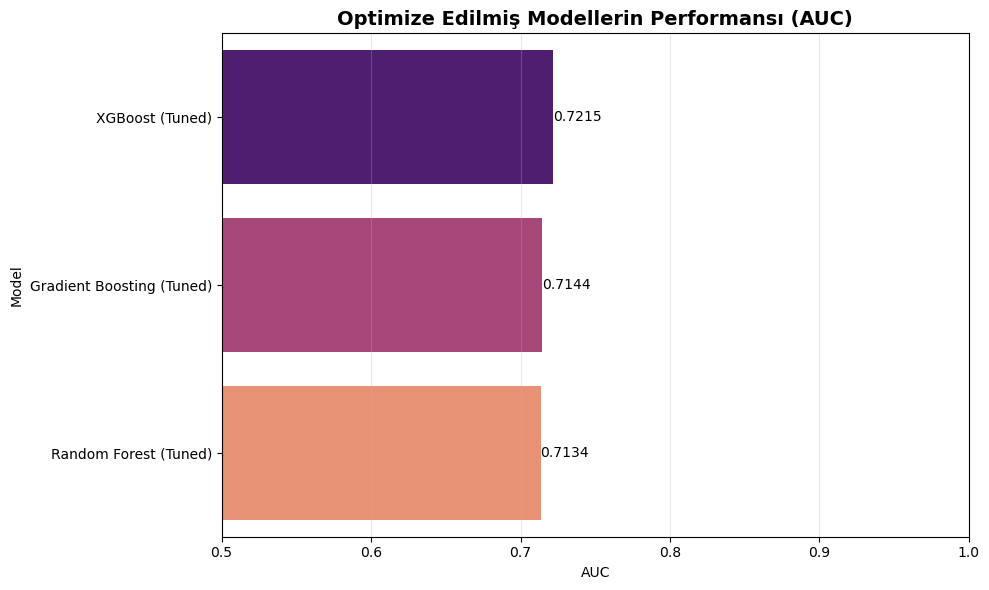


FİNAL TUNING SONUCU:
Hiperparametre optimizasyonu sonrası en iyi sonucu XGBoost (Tuned) verdi.
Maksimum AUC Skoru: 0.7215


In [27]:
df_tuned = pd.DataFrame(tuned_results).sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("\nOPTİMİZE EDİLMİŞ MODEL SONUÇLARI")
print(df_tuned.to_string())

plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=df_tuned, palette='magma')
plt.title('Optimize Edilmiş Modellerin Performansı (AUC)', fontsize=14, fontweight='bold')
plt.xlim(0.5, 1.0)
plt.grid(axis='x', alpha=0.3)
for index, value in enumerate(df_tuned['AUC']):
    plt.text(value, index, f'{value:.4f}', va='center')
plt.tight_layout()
plt.show()

best_tuned = df_tuned.iloc[0]
print(f"\nFİNAL TUNING SONUCU:")
print(f"Hiperparametre optimizasyonu sonrası en iyi sonucu {best_tuned['Model']} verdi.")
print(f"Maksimum AUC Skoru: {best_tuned['AUC']:.4f}")

In [11]:
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from time import time
import numpy as np

print("--- AGRESİF XGBOOST TUNING BAŞLIYOR ---")

# 1. Dengesizlik Ayarı
spw_value = float(sum(y_train == 0)) / sum(y_train == 1)
print(f"Dengesizlik Katsayısı (Scale Pos Weight): {spw_value:.4f}")

# 2. Daha Geniş ve Detaylı Parametre Uzayı
xgb_params = {
    'n_estimators': randint(200, 1000),      # Ağaç sayısını artırdık
    'learning_rate': uniform(0.005, 0.2),    # Daha hassas öğrenme oranları
    'max_depth': randint(3, 12),             # Derinlik aralığı genişledi
    'min_child_weight': randint(1, 10),      # Yaprak başına düşen minimum ağırlık
    'gamma': uniform(0, 0.6),                # Bölünme için minimum kayıp düşüşü
    'subsample': uniform(0.6, 0.4),          # Her ağaçta verinin %60-%100'ünü kullan
    'colsample_bytree': uniform(0.5, 0.5),   # Her ağaçta sütunların %50-%100'ünü kullan
    'reg_alpha': uniform(0, 1),              # L1 Regularization 
    'reg_lambda': uniform(1, 3),             # L2 Regularization
    'scale_pos_weight': [spw_value]          # Dengesizlik ayarı
}

tuned_results = []

def tune_and_save(model, params, name, n_iter=50):
    print(f"\n{name} için en iyi konfigürasyon aranıyor (Toplam {n_iter} deneme)...")
    start = time()
    

    random_search = RandomizedSearchCV(
        model, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='roc_auc', 
        cv=5, 
        verbose=1, 
        random_state=42, 
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    duration = time() - start
    
    # En İyi Model
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Test Seti Üzerinde Tahminler
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"\nOptimizasyon Tamamlandı! Süre: {duration:.2f} saniye")
    print(f"EN İYİ SKORLAR:")
    print(f"   AUC (Area Under Curve): {auc:.5f}")
    print(f"   F1 Skoru              : {f1:.5f}")
    print(f"   Doğruluk (Accuracy)   : {acc:.5f}")
    print(f"Kazanan Parametreler:\n{best_params}")
    
    # Sonuçları listeye atalım
    tuned_results.append({
        'Model': name + " (Pro Tuned)",
        'AUC': auc,
        'Best Params': best_params
    })
    
    filename = 'best_model.pkl'
    joblib.dump(best_model, filename)
    print(f"\nModel başarıyla '{filename}' adıyla kaydedildi.")
    
    return best_model

# 3. Çalıştır
# n_iter=50 ile çalıştırıyoruz. Bilgisayarın hızına göre 2-5 dk sürebilir.
xgb_tuned = tune_and_save(
    XGBClassifier(eval_metric='logloss', random_state=42), 
    xgb_params, 
    "XGBoost", 
    n_iter=50
)

best_tuned = xgb_tuned
final_model = xgb_tuned

--- AGRESİF XGBOOST TUNING BAŞLIYOR ---
Dengesizlik Katsayısı (Scale Pos Weight): 3.1254

XGBoost için en iyi konfigürasyon aranıyor (Toplam 50 deneme)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Optimizasyon Tamamlandı! Süre: 4238.86 saniye
EN İYİ SKORLAR:
   AUC (Area Under Curve): 0.72397
   F1 Skoru              : 0.71661
   Doğruluk (Accuracy)   : 0.70313
Kazanan Parametreler:
{'colsample_bytree': np.float64(0.8658238776498202), 'gamma': np.float64(0.07661383765347936), 'learning_rate': np.float64(0.055003289843220934), 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': np.float64(0.5618666921437736), 'reg_lambda': np.float64(1.7157905793710206), 'scale_pos_weight': 3.1253811407508945, 'subsample': np.float64(0.8719379119600983)}

Model başarıyla 'best_model.pkl' adıyla kaydedildi.


In [12]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 3.9 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



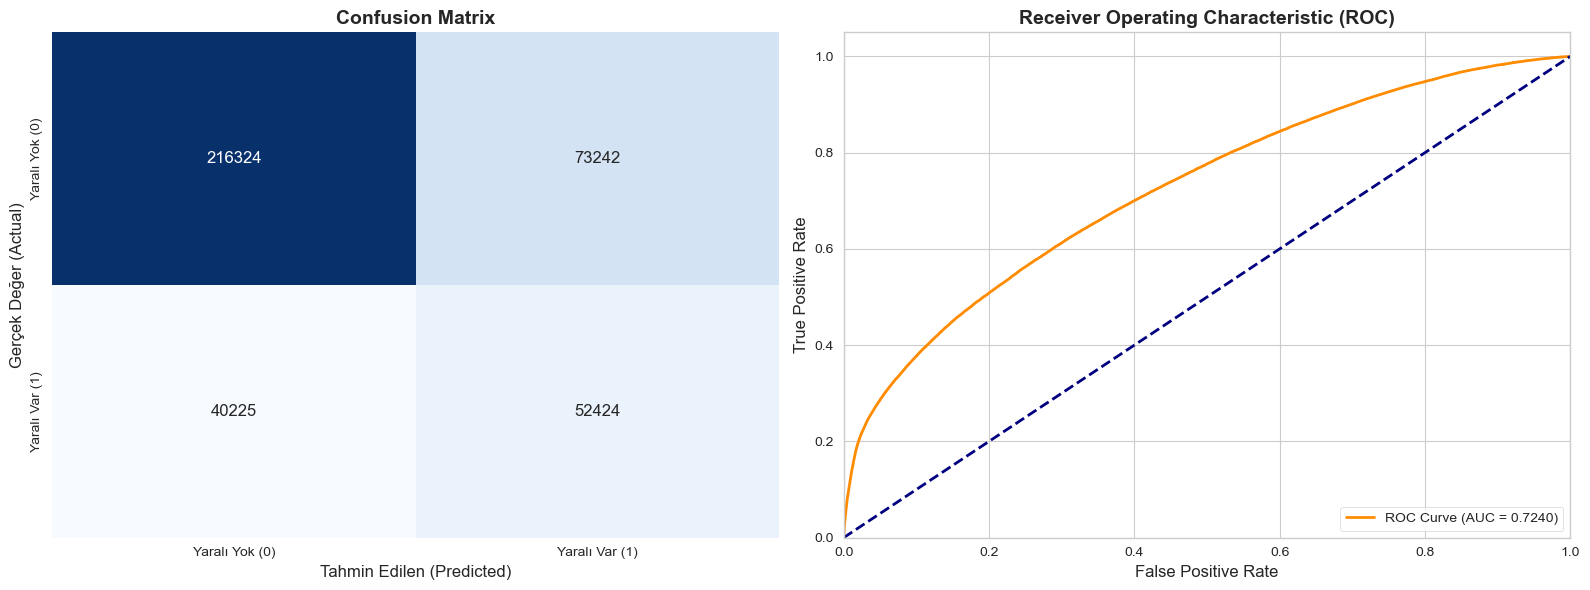

SHAP analizi hesaplanıyor...


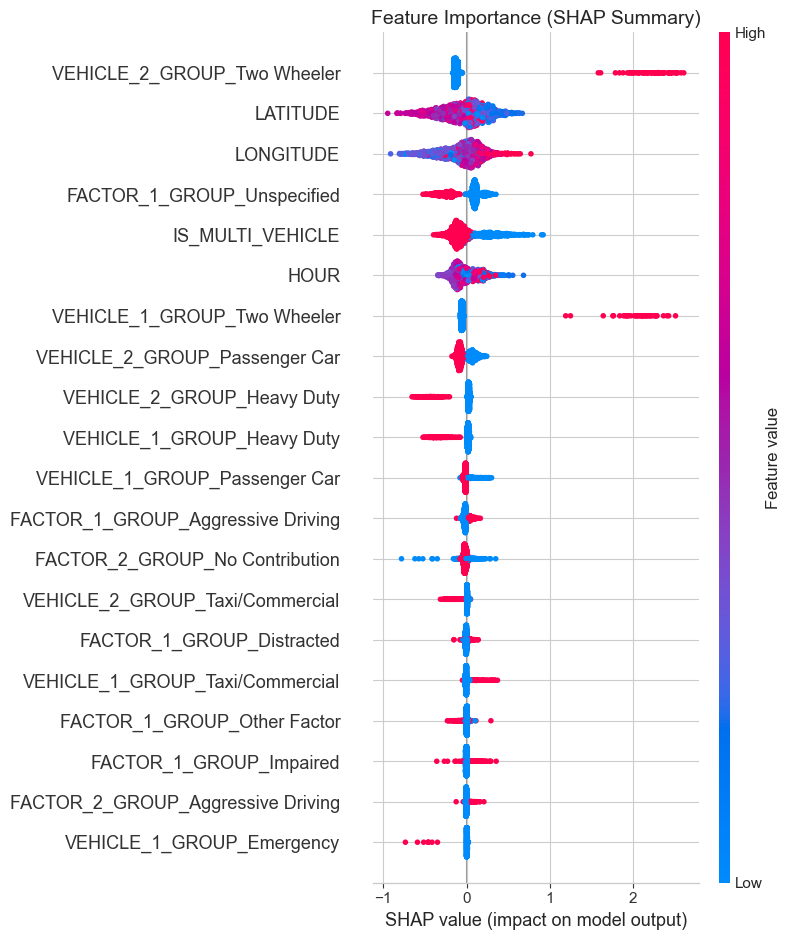

In [13]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Grafik stili ve düzeni
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# --- 1. Confusion Matrix ---
plt.subplot(1, 2, 1)
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Tahmin Edilen (Predicted)')
plt.ylabel('Gerçek Değer (Actual)')
plt.xticks([0.5, 1.5], ['Yaralı Yok (0)', 'Yaralı Var (1)'])
plt.yticks([0.5, 1.5], ['Yaralı Yok (0)', 'Yaralı Var (1)'])

# --- 2. ROC Curve ---
plt.subplot(1, 2, 2)
y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# --- 3. SHAP Feature Importance Analizi ---
print("SHAP analizi hesaplanıyor...")

# Hesaplama performansı için örneklem alma
if len(X_test) > 2000:
    X_test_shap = X_test.sample(2000, random_state=42)
else:
    X_test_shap = X_test

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_shap)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance (SHAP Summary)', fontsize=14)
shap.summary_plot(shap_values, X_test_shap, show=True, plot_type="dot")